# Universal $\mathcal{P}_1(\mathbb{R})$-Deep Neural Model
---

## Meta-Parameters

### Visualization

In [1]:
# How many random polulations to visualize:
Visualization_Size = 4

### Simulation

In [2]:
## Monte-Carlo
# N_Euler_Maruyama_Steps = 2
N_Monte_Carlo_Samples = 1

## Grid
N_Grid_Finess = 20
Max_Grid = 1

### Quantization
*This hyperparameter describes the proportion of the data used as sample-barycenters.*

In [3]:
Quantization_Proportion = 1

**Note**: Setting *N_Quantizers_to_parameterize* prevents any barycenters and sub-sampling.

# Training Algorithm
---
Given a set of training inputs $\mathbb{X}$ and a stochastic process $(X_t)_{t\geq 0}$ which we can sample from:
1. **For:** x in $\mathbb{X}$:
    - *Simulate:* $\{x\mapsto X_T(\omega_n)\}_{n=1}^N$
    - *Set*: $\hat{\nu}_{x,T}\triangleq \frac1{N}\sum_{n=1}^N \delta_{X_T(\omega_n)}$
2. **Learn:** Wasserstein Barycenters $\hat{\mu}_1,\dots,\hat{\mu}_N
    \in \underset{{\hat{\mu}_n\in\mathscr{P}_{N}(\mathbb{R}^d)}}{\operatorname{argmin}}
    \, \sum_{n=1}^N W_1(\hat{\mu_n},\hat{\nu}_{x,T})$
3. **Train Classifier:** $\hat{f}:x\mapsto \operatorname{n\leq N}\, W_1(\hat{\mu_n},\hat{\nu}_{x,T})$

#### Mode: Code-Testin Parameter(s)

In [4]:
trial_run = True

### Meta-parameters

In [5]:
# Test-size Ratio
test_size_ratio = 1

### Hyperparameters

Only turn of if running code directly here, typically this script should be run be called by other notebooks.  

In [6]:
# load dataset
results_path = "./outputs/models/"
results_tables_path = "./outputs/results/"
raw_data_path_folder = "./inputs/raw/"
data_path_folder = "./inputs/data/"

### Import

In [7]:
# Load Packages/Modules
exec(open('Init_Dump.py').read())
# Load Hyper-parameter Grid
exec(open('Grid_Enhanced_Network.py').read())
# Load Helper Function(s)
exec(open('Helper_Functions.py').read())
# Import time separately
import time

Using TensorFlow backend.


Deep Feature Builder - Ready
Deep Classifier - Ready


## Get Internal (Hyper)-Parameter(s)
*Initialize the hyperparameters which are fully-specified by the user-provided hyperparameter(s).*

### Initialize Grid
This is $\mathbb{X}$ and it represents the grid of initial states.

In [8]:
# Get Input Data
x_Grid = np.arange(start=-Max_Grid,
                   stop=Max_Grid,
                   step=(2*Max_Grid/N_Grid_Finess))

# Get Number of Instances in Grid
N_Grid_Instances = len(x_Grid)

# Updater User
print("\u2022 Grid Instances: ", N_Grid_Instances)

• Grid Instances:  20


### Initialize Counting Parameters
Initialize the "conting" type parameters which will help us to determine the length of loops and to intialize object's size later on.  

In [9]:
# Get Internal (Counting) Parameters
N_Quantizers_to_parameterize = round(Quantization_Proportion*N_Grid_Finess)
N_Elements_Per_Cluster = int(round(N_Grid_Instances/N_Quantizers_to_parameterize))

# Update User
print("\u2022",N_Quantizers_to_parameterize," Centers will be produced; from a total datasize of: ",N_Grid_Finess,
      "!  (That's ",Quantization_Proportion,
      " percent).")
print("\u2022 Each Wasserstein-1 Ball should contain: ",
      N_Elements_Per_Cluster, 
      "elements from the training set.")

• 20  Centers will be produced; from a total datasize of:  20 !  (That's  1  percent).
• Each Wasserstein-1 Ball should contain:  1 elements from the training set.


### Set Seed

In [10]:
random.seed(2021)
np.random.seed(2021)
tf.random.set_seed(2021)

---

### Simulate Path
$d X_t = \alpha(t,x)dt + \beta(t,x)dW_t ;\qquad X_0 =x$

### Drift

In [11]:
def alpha(t,x):
    return 0#np.sin(math.pi*t)

### Volatility

In [12]:
def beta(t,x):
    return 1#(t+1)**.5

---

In [13]:
# Initialize List of Barycenters
Wasserstein_Barycenters = []
# Initialize Terminal-Time Empirical Measures
measures_locations_list = []
measures_weights_list = []
# Initialize (Empirical) Weight(s)
measure_weights = np.ones(N_Monte_Carlo_Samples)/N_Monte_Carlo_Samples
# Initialize Quantizer
Init_Quantizer_generic = np.ones(N_Monte_Carlo_Samples)/N_Monte_Carlo_Samples

## Generate $\{\hat{\nu}^{N}_{T,x}\}_{x \in \mathbb{X}}$ Build Wasserstein Cover

#### Get Data

In [14]:
# Update User
print("Current Monte-Carlo Step:")

# Perform Monte-Carlo Data Generation
for i in tqdm(range(N_Grid_Instances)):
    # Get Terminal Distribution Shape
    ###
    # DIRECT SAMPLING
    measures_locations_loop = (np.random.normal(x_Grid[i],np.abs(x_Grid[i]), N_Monte_Carlo_Samples).reshape(-1,))/N_Monte_Carlo_Samples
    
    # Append to List
    measures_locations_list.append(measures_locations_loop.reshape(-1,1))
    measures_weights_list.append(measure_weights)
    
# Update User
print("Done Simulation Step")

100%|██████████| 20/20 [00:00<00:00, 35187.11it/s]

Current Monte-Carlo Step:
Done Simulation Step


#### Get Cover

## Get "Sample Barycenters":
Let $\{\mu_n\}_{n=1}^N\subset\mathcal{P}_1(\mathbb{R}^d)$.  Then, the *sample barycenter* is defined by:
1. $\mathcal{M}^{(0)}\triangleq \left\{\hat{\mu}_n\right\}_{n=1}^N$,
2. For $1\leq n\leq \mbox{N sample barycenters}$: 
    - $
\mu^{\star}\in \underset{\tilde{\mu}\in \mathcal{M}^{(n)}}{\operatorname{argmin}}\, \sum_{n=1}^N \mathcal{W}_1\left(\mu^{\star},\mu_n\right),
$
    - $\mathcal{M}^{(n)}\triangleq \mathcal{M}^{(n-1)} - \{\mu^{\star}\},$
*i.e., the closest generated measure form the random sample to all other elements of the random sample.*

---
**Note:** *We simplify the computational burden of getting the correct classes by putting this right into this next loop.*

---

## Build Dissimilarity (Distance) Matrix
*In this step we build a dissimularity matrix of the dataset on the Wasserstein-1 space.  Namely:*
$$
\operatorname{Mat}_{\# \mathbb{X},\# \mathbb{X}}\left(\mathbb{R}\right)\ni D; \text{ where}\qquad \, D_{i,j}\triangleq \mathcal{W}_1\left(f(x_i),f(x_j)\right)
;
$$
*where $f\in C\left((\mathcal{X},\mathcal{P}_1(\mathcal{Y})\right)$ is the "target" function we are learning.*

**Note**: *Computing the dissimularity matrix is the most costly part of the entire algorithm with a complexity of at-most $\mathcal{O}\left(E_{W} \# \mathbb{X})^2\right)$ where $E_W$ denotes the complexity of a single Wasserstein-1 evaluation between two elements of the dataset.*

In [15]:
# Initialize Disimilarity Matrix
Dissimilarity_matrix_ot = np.zeros([N_Grid_Instances,N_Grid_Instances])


# Update User
print("\U0001F61A"," Begin Building Distance Matrix"," \U0001F61A")
# Build Disimilarity Matrix
for i in tqdm(range(N_Grid_Instances)):
    for j in range(N_Grid_Instances):
        Dissimilarity_matrix_ot[i,j] = ot.emd2_1d(measures_locations_list[j],
                                                  measures_locations_list[i])
# Update User
print("\U0001F600"," Done Building Distance Matrix","\U0001F600","!")

  0%|          | 0/20 [00:00<?, ?it/s]

😚  Begin Building Distance Matrix  😚


100%|██████████| 20/20 [00:00<00:00, 371.93it/s]

😀  Done Building Distance Matrix 😀 !


## Initialize Quantities to Loop Over

## Get "Sample Barycenters" and Generate Classes

In [16]:
# Initialize Locations Matrix (Internal to Loop)
measures_locations_list_current = copy.copy(measures_locations_list)
Dissimilarity_matrix_ot_current = copy.copy(Dissimilarity_matrix_ot)

# Initialize masker vector
masker = np.ones(N_Grid_Instances)

# Initialize Sorting Reference Vector (This helps us efficiently scroll through the disimularity matrix to identify the barycenter without having to re-compute the dissimultarity matrix of a sub-saple at every iteration (which is the most costly part of the algorithm!))
Distances_Loop = Dissimilarity_matrix_ot_current.sum(axis=1)

# Initialize Classes (In-Sample)
Classifer_Wasserstein_Centers = np.zeros([N_Quantizers_to_parameterize,N_Grid_Instances])

In [17]:
# Update User
print("\U0001F61A"," Begin Identifying Sample Barycenters"," \U0001F61A")

# Identify Sample Barycenters
for i in tqdm(range(N_Quantizers_to_parameterize)):    
    # GET BARYCENTER #
    #----------------#
    ## Identify row with minimum total distance
    Barycenter_index = int(Distances_Loop.argsort()[:1][0])
    ## Get Barycenter
    ## Update Barycenters Array ##
    #----------------------------#
    ### Get next Barycenter
    new_barycenter_loop = measures_locations_list_current[Barycenter_index].reshape(-1,1)
    ### Update Array of Barycenters
    if i == 0:
        # Initialize Barycenters Array
        Barycenters_Array = new_barycenter_loop
    else:
        # Populate Barycenters Array
        Barycenters_Array = np.append(Barycenters_Array,new_barycenter_loop,axis=-1)

    # GET CLUSTER #
    #-------------#
    # Identify Cluster for this barycenter (which elements are closest to it)
    Cluster_indices = (masker*Dissimilarity_matrix_ot_current[:,Barycenter_index]).argsort()[:N_Elements_Per_Cluster]
    ## UPDATES Set  M^{(n)}  ##
    #-------------------------#
    Dissimilarity_matrix_ot_current[Cluster_indices,:] = 0
    # Distance-Based Sorting
    Distances_Loop[Cluster_indices] = math.inf

    # Update Cluster
    masker[Cluster_indices] = math.inf
    
    # Update Classes
    Classifer_Wasserstein_Centers[i,Cluster_indices] = 1
#     print(Cluster_indices)

# Update User
print("\U0001F600"," Done Identifying Sample Barycenters","\U0001F600","!")
print(Classifer_Wasserstein_Centers)

100%|██████████| 20/20 [00:00<00:00, 10826.80it/s]

😚  Begin Identifying Sample Barycenters  😚
😀  Done Identifying Sample Barycenters 😀 !
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

---

### Train Classifier

In this step, we train a deep (feed-forward) classifier:
$$
\hat{f}\triangleq \operatorname{Softmax}_N\circ W_J\circ \sigma \bullet \dots \sigma \bullet W_1,
$$
to identify which barycenter we are closest to.

#### Deep Classifier
Prepare Labels/Classes

In [18]:
# Time-Elapsed Training Deep Classifier
Type_A_timer_Begin = time.time()

Re-Load Grid and Redefine Relevant Input/Output dimensions in dictionary.

#### Train Deep Classifier

In [19]:
# Re-Load Hyper-parameter Grid
exec(open('Grid_Enhanced_Network.py').read())
# Re-Load Classifier Function(s)
exec(open('Helper_Functions.py').read())
# %run ParaGAN_Backend.ipynb

Deep Feature Builder - Ready
Deep Classifier - Ready


In [20]:
# Redefine (Dimension-related) Elements of Grid
# param_grid_Deep_Classifier['input_dim'] = [1]
param_grid_Deep_Classifier['output_dim'] = [N_Quantizers_to_parameterize]

# Train simple deep classifier
predicted_classes_train, predicted_classes_test, N_params_deep_classifier = build_simple_deep_classifier(n_folds = CV_folds, 
                                                                                                        n_jobs = n_jobs, 
                                                                                                        n_iter = n_iter, 
                                                                                                        param_grid_in=param_grid_Deep_Classifier, 
                                                                                                        X_train = x_Grid, 
                                                                                                        y_train = Classifer_Wasserstein_Centers.T,
                                                                                                        X_test = x_Grid)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    4.2s finished


Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 2.9755 - accuracy: 0.1000
Epoch 2/100
1/1 [==============================] - 0s 984us/step - loss: 2.9668 - accuracy: 0.1000
Epoch 3/100
1/1 [==============================] - 0s 1ms/step - loss: 2.9583 - accuracy: 0.1000
Epoch 4/100
1/1 [==============================] - 0s 907us/step - loss: 2.9498 - accuracy: 0.1000
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 2.9415 - accuracy: 0.1000
Epoch 6/100
1/1 [==============================] - 0s 1ms/step - loss: 2.9332 - accuracy: 0.1500
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 2.9249 - accuracy: 0.1000
Epoch 8/100
1/1 [==============================] - 0s 3ms/step - loss: 2.9165 - accuracy: 0.1000
Epoch 9/100
1/1 [==============================] - 0s 4ms/step - loss: 2.9078 - accuracy: 0.1000
Epoch 10/100
1/1 [==============================] - 0s 3ms/step - loss: 2.8990 - accuracy: 0.1000
Epoch 11/100
1/1 [=======

1/1 [==============================] - 0s 3ms/step - loss: 2.0787 - accuracy: 0.3000
Epoch 85/100
1/1 [==============================] - 0s 2ms/step - loss: 2.0695 - accuracy: 0.3000
Epoch 86/100
1/1 [==============================] - 0s 1ms/step - loss: 2.0602 - accuracy: 0.3000
Epoch 87/100
1/1 [==============================] - 0s 2ms/step - loss: 2.0509 - accuracy: 0.3000
Epoch 88/100
1/1 [==============================] - 0s 1ms/step - loss: 2.0415 - accuracy: 0.3000
Epoch 89/100
1/1 [==============================] - 0s 2ms/step - loss: 2.0321 - accuracy: 0.3000
Epoch 90/100
1/1 [==============================] - 0s 1ms/step - loss: 2.0225 - accuracy: 0.3000
Epoch 91/100
1/1 [==============================] - 0s 3ms/step - loss: 2.0128 - accuracy: 0.3000
Epoch 92/100
1/1 [==============================] - 0s 2ms/step - loss: 2.0030 - accuracy: 0.3000
Epoch 93/100
1/1 [==============================] - 0s 1ms/step - loss: 1.9930 - accuracy: 0.3000
Epoch 94/100
1/1 [===============

#### Get Predicted Quantized Distributions
- Each *row* of "Predicted_Weights" is the $\beta\in \Delta_N$.
- Each *Column* of "Barycenters_Array" denotes the $x_1,\dots,x_N$ making up the points of the corresponding empirical measures.

In [39]:
# Format Weights
Predicted_Weights = np.array([])
for i in range(N_Quantizers_to_parameterize):
    b = np.repeat(np.array(Classifer_Wasserstein_Centers.T[:,i],dtype='float').reshape(-1,1),N_Monte_Carlo_Samples,axis=-1)
    b = b/N_Monte_Carlo_Samples
    if i ==0 :
        Predicted_Weights = b
    else:
        Predicted_Weights = np.append(Predicted_Weights,b,axis=1)
        
# Format Points of Mass
Barycenters_Array = Barycenters_Array.T.reshape(-1,)

## Get Moment Predictions

#### Write Predictions

Compute Performance

In [56]:
hello=5
print(np.round(Barycenters_Array,4))
print(Predicted_Weights[hello,].reshape(-1,))
print(measures_locations_list[hello].reshape(-1,))
print(measures_weights_list[hello].reshape(-1,))

[-0.0578 -0.1065 -0.      0.0162  0.0523 -0.1787 -0.2414 -0.2665 -0.269
 -0.2916 -0.3631  0.2818  0.3308  0.4886  0.5424 -0.8528 -1.1348  1.0501
 -1.2646  1.1733]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[-0.85275214]
[1.]


In [52]:
# Initialize Wasserstein-1 Error Distribution
W1_errors = np.array([])
Mean_errors = np.array([])
#---------------------------------------------------------------------------------------------#

# Populate Error Distribution
for x_i in range(len(measures_locations_list)):
    # Get Laws
    W1_loop = ot.emd2_1d(Barycenters_Array,
                         measures_locations_list[x_i].reshape(-1,),
                         Predicted_Weights[x_i,].reshape(-1,),
                         measures_weights_list[x_i].reshape(-1,))
    W1_errors = np.append(W1_errors,W1_loop)
    # Get Means
    b = np.mean((Predicted_Weights[x_i])*(Barycenters_Array))
    Mean_errors = np.array(b-np.mean(measures_locations_list[x_i]))
    # Get Vars
    b = np.mean((Predicted_Weights[x_i]**2)*(Barycenters_Array))
    Mean_var = np.array(b-np.mean(measures_locations_list[x_i]**2))
    
#---------------------------------------------------------------------------------------------#
# Compute Error Statistics/Descriptors
W1_Performance = np.array([np.mean(np.abs(W1_errors)),np.mean(W1_errors**2)])
Mean_prediction_Performance = np.array([np.mean(np.abs(Mean_errors)),np.mean(Mean_errors**2)])
Var_prediction_Performance = np.array([np.mean(np.abs(Mean_var)),np.mean(Mean_var**2)])

Type_A_Prediction = pd.DataFrame({"W1":W1_Performance,
                                  "E[X']-E[X]":Mean_prediction_Performance,
                                  "E[X'^2]-E[X^2]":Var_prediction_Performance},index=["MAE","MSE"])

# Write Performance
Type_A_Prediction.to_latex((results_tables_path+"Type_A_Prediction.tex"))


#---------------------------------------------------------------------------------------------#
# Update User
print(Type_A_Prediction)

      W1  E[X']-E[X]  E[X'^2]-E[X^2]
MAE  0.0    1.114682        1.318081
MSE  0.0    1.242516        1.737338


# Visualization of Performance
Randomly subsample from output space and visualize empirical measures!

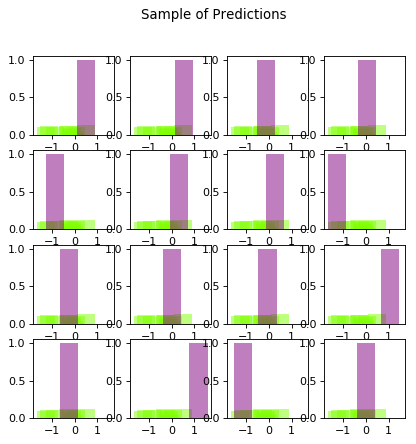

In [38]:
# Adjust if is number of plots to visualizes is larger than number of output distributions (But only if there is not enough data!)
if N_Grid_Instances <= Visualization_Size**2:
        Visualization_Size = int(round(np.sqrt(min(N_Grid_Instances,Visualization_Size**2)))-1)


# Initialize Random Sample of input-output pairs to visualize
plotting_distribution_indices = random.sample(range(N_Grid_Instances), (Visualization_Size)**2)

# Generate Plot
f, axarr = plt.subplots(Visualization_Size,Visualization_Size,figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')
plt.suptitle("Sample of Predictions")
for i in range(Visualization_Size):
    for j in range(Visualization_Size):
        # Get Current (Randomly chosen (uniformly)) Index
        current_index = (i*Visualization_Size + j)
        current_random_index = plotting_distribution_indices[current_index]
        # Generate Current Plot
        axarr[i,j].bar(Barycenters_Array,(Predicted_Weights[5].reshape(-1,)), alpha=0.5,label="Prediction",color="chartreuse")
        axarr[i,j].bar(measures_locations_list[current_random_index].reshape(-1,),measures_weights_list[current_random_index], alpha=0.5,label="Target",color="purple")

---

---
# Fin
---

---